# Health insurance cross sell prediction with XGBoost

## 1. Problem description

[This dataset](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) contains a list of health insurance customers. The "Response" column indicates whether the customer also wanted to use car insurance.

I'll try to build an effective model that predicts this decision using XGBoost, Optuna hyperparameters tuning, feature encoding, feature selection and few other tricks. First I'll do some classic (non-ML) data analysis and later I'll try to go a little deeper into how the model works.

In [1]:
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")


print("Number of rows:", df.shape[0])
df.head()

Number of rows: 381109


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 2. Initial data visualization, columns explanation, EDA
TODO

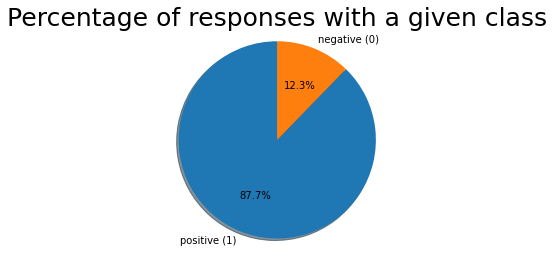

In [2]:
labels = ["positive (1)", "negative (0)"]
negative = df[df.Response == 0].size
positive = df[df.Response == 1].size
sizes = [negative, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of responses with a given class", fontsize=25)
plt.show()

People who choose both insurances outnumber those who do not (87,7%).

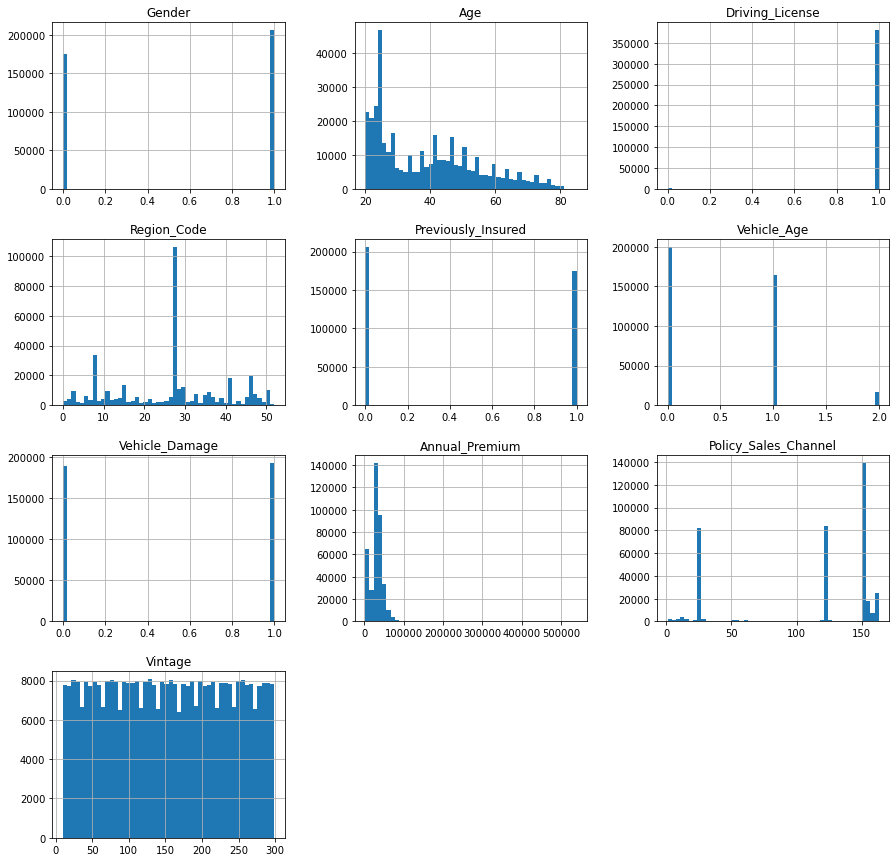

In [3]:
X_le.hist(bins=50, figsize=(15, 15))
plt.show()

1. ***Gender*** - there are slightly more males than females.
2. ***Age*** - the majority of people are between the ages of 20 and 30. There is also a second, smaller peak around the age of 45.
3. ***Driving_License*** - the vast majority of customers have a driver's license.
4. ***Region_Code*** - some regions have many more customers than others.
5. ***Previously_Insured*** - this column indicates whether or not a customer has insurance (0 = no, 1 = yes). 54% don't have one.
6. ***Vehicle_Age*** - most people have young cars (less than 1 year old), slightly fewer in the 1-2 year range, and noticeably fewer over 2 years old.
7. ***Vehicle_Damage*** - a similar proportion of customers have a car with and without damage.
8. ***Annual_Premium*** - this feature describes "the amount customer needs to pay as premium in the year". The column resembles most data with salaries - it has a long "right tail".
9. ***Policy_Sales_Channel*** - there is no detailed description of the specific values of this column. Some sales channels are orders of magnitude more likely to be used than others.
10. ***Vintage*** - "number of days, customer has been associated with the company. The column has very even distribution - the company most likely received a similar number of customers throughout the year.

### 2.1 Mutual information
Mutual information is a tool for measuring the dependence between two variables. It uses the "K nearest neighbors" algorithm to describe it.

In [17]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_le, y, random_state=42, discrete_features=[0, 1, 2, 3, 4, 5, 6, 7, 9], )
pd.Series(mi, name="MI Scores", index=X_le.columns).sort_values(ascending=False)

Previously_Insured      0.079515
Vehicle_Damage          0.079027
Annual_Premium          0.068894
Policy_Sales_Channel    0.059944
Age                     0.030097
Vehicle_Age             0.026214
Region_Code             0.009445
Gender                  0.001388
Vintage                 0.000342
Driving_License         0.000064
Name: MI Scores, dtype: float64

### 2.2 KDE plots

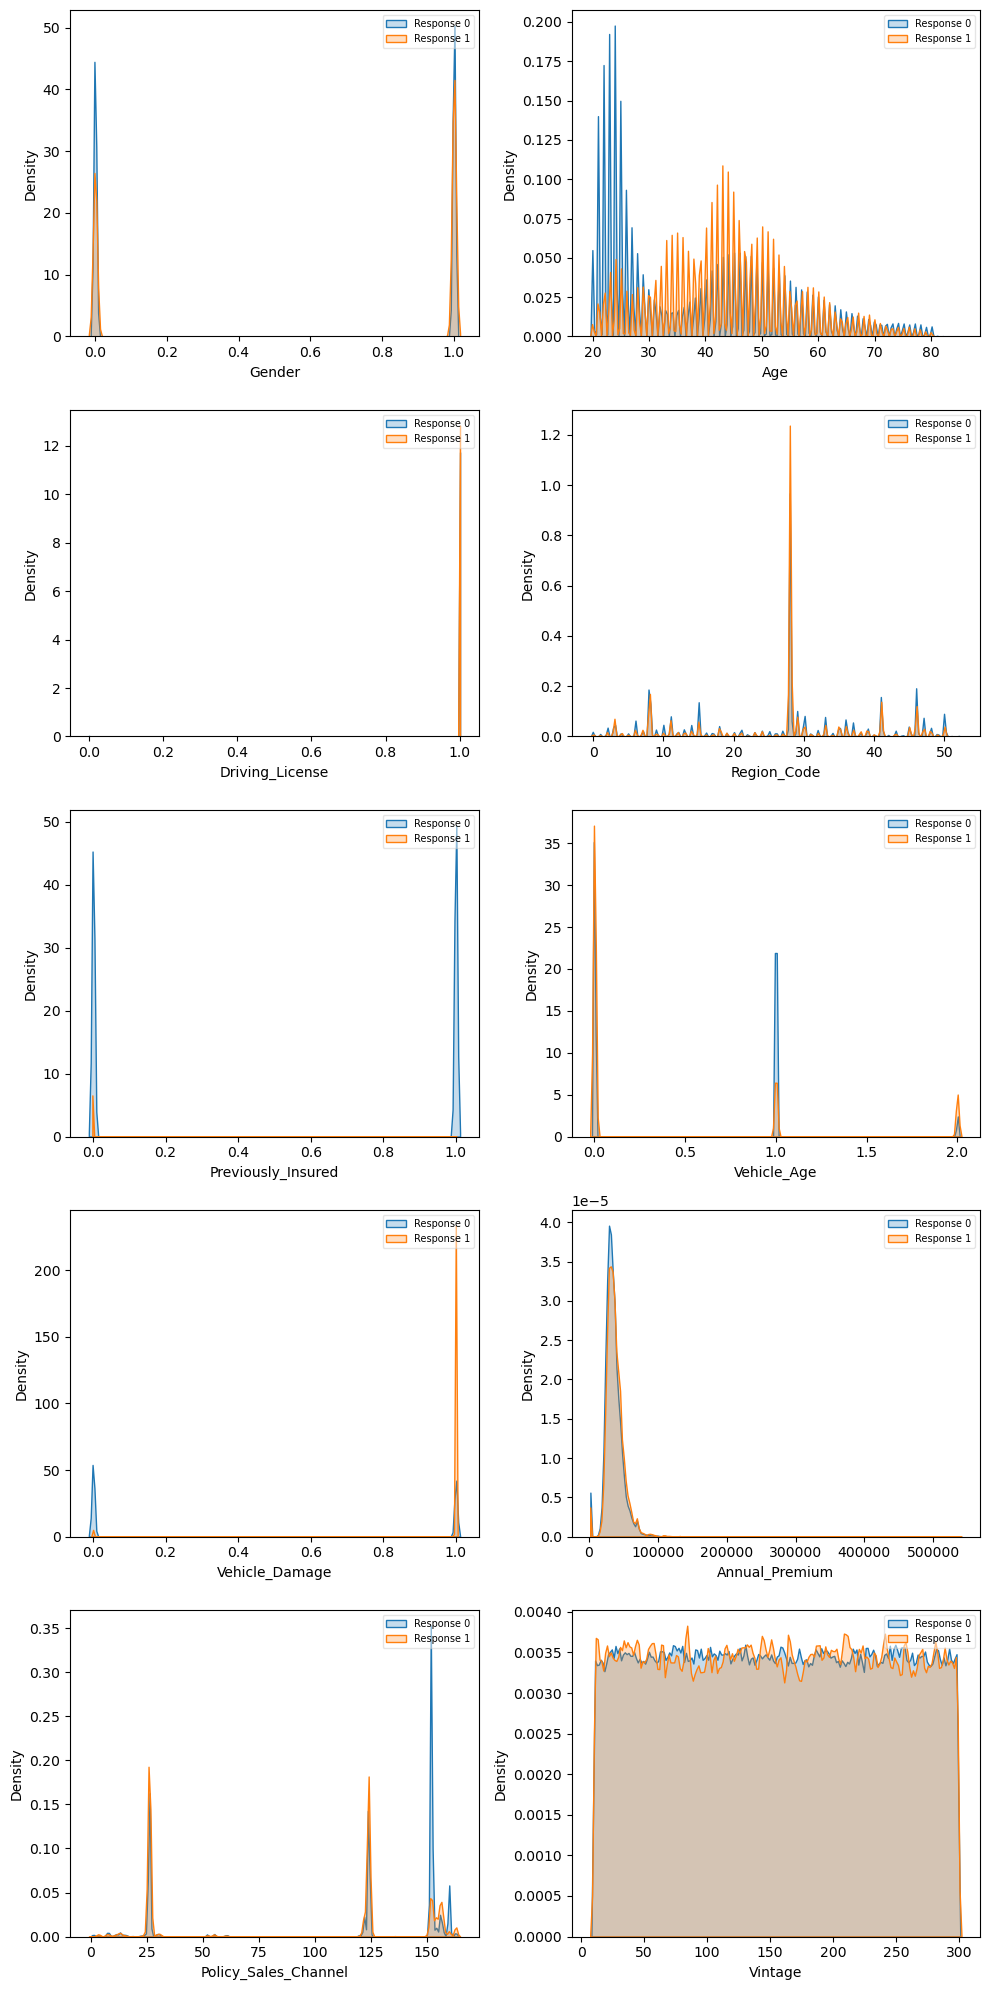

In [6]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
dfresponse0 = df_le[df_le["Response"] == 0]
dfresponse1 = df_le[df_le["Response"] == 1]

cols = df_le.drop(columns='Response').columns

height = 5
width = math.ceil(len(cols) / height)

fig, ax = plt.subplots(height, width, figsize=(10,20))
index=0
for columnX in cols:
#     TODO: use better value of bw_adjust?
    sns.kdeplot(data=dfresponse0[columnX], label="Response 0", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    sns.kdeplot(data=dfresponse1[columnX], label="Response 1", shade=True, ax=ax[index//width][index % width], bw_adjust=0.1)
    ax[index//width][index % width].legend(loc='best', prop={'size': 7}, fancybox=True, framealpha=0.5)
    index+=1

# while index < height * width:
#     ax[index//width][index % width].axis('off')
#     index+=1
fig.tight_layout()
plt.show()

1. Gender - at first glance, we can see that a higher percentage of men (label 1) opt for car insurance. The relationship is noticeable, but not very strong.
2. Age - young people are usually not interested in the service, the most frequent users are those aged 40-50. Among people of a particular age the relationship is quite strong - the percentage can vary as much as 3-4 times. In some ranges, however, the difference is not large - for example, around the age of 30.
3. Region_Code - people in certain regions have a much higher or lower percentage of service users, but it is also important to keep in mind how regions vary in the total number of customers.
4. Previously_Insured - people with insurance usually do not want to buy a new one, contrary to people without insurance. The relationship is very strong.
5. Vehicle_Age (0 - '1-2 Year', 1 - '< 1 Year', 2 - '> 2 Years') - people prefer to insure old cars over new ones.
6. Vehicle_Damage 0 - 'no', 1 - 'yes' - we can see that damaged cars have a much higher percentage of insurance.
7. Annual_Premium - it's difficult to determine from the raw data, it is better to present a second graph with the logarithm of the feature.
8. Policy_Sales_Channel - insurance percentages can vary widely for specific sales channels.
9. Vintage - this feature is unlikely to affect the outcome.

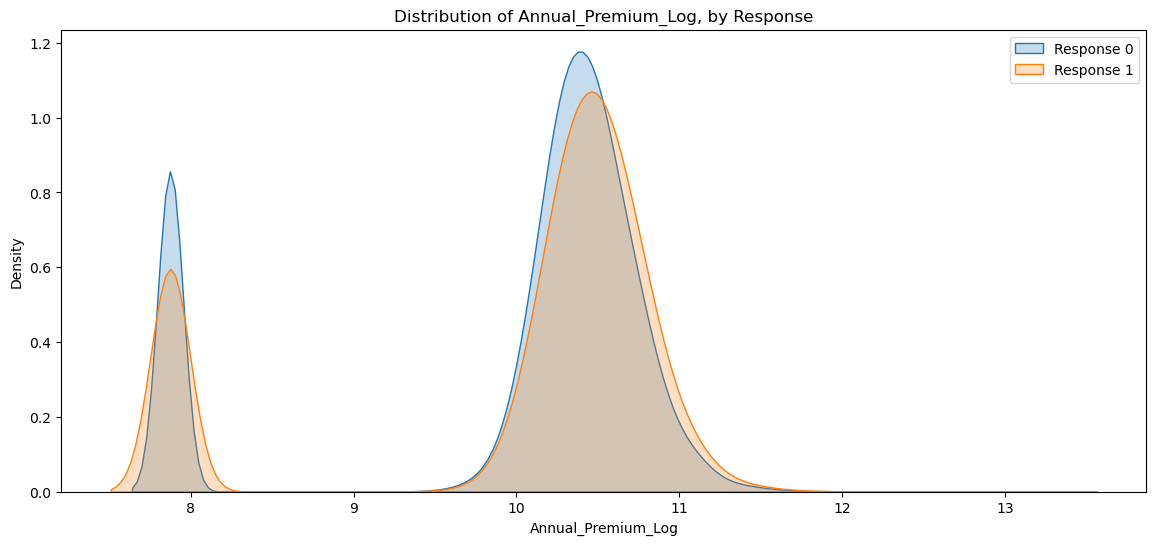

In [29]:
df_log = df_le[['Annual_Premium', 'Response']].copy()
df_log['Annual_Premium_Log'] = np.log(df['Annual_Premium'])

dfresponse0 = df_log[df_log["Response"] == 0]
dfresponse1 = df_log[df_log["Response"] == 1]

plt.figure(figsize=(14,6))
sns.kdeplot(data=dfresponse0['Annual_Premium_Log'], label="Response 0", shade=True)
sns.kdeplot(data=dfresponse1['Annual_Premium_Log'], label="Response 1", shade=True)

plt.title("Distribution of Annual_Premium_Log, by Response")
plt.legend()
plt.show()

Here we can see, that Annual_Premium affects output. It's not so easy to describe, but model probably will be able to use this information properly.

## 3. Basic model with logistic regression
TODO

### 3.1 Metric
This problem is an example of an "imbalanced dataset". It means that one class ("negative" or "zero" in this article) has significantly more samples than the others. You can get 87.7% accuracy... just by assigning the same prediction to all cases! There are more reliable metrics for imbalanced datasets - one of them is ROC AUC.

#### 3.1.1 True positive rate, False positive rate
For a proper understanding of the ROC AUC metric, it is necessary first to explain TPR (true positive rate) and FPR (false positive rate).

The "true positive rate" is the number of properly predicted positive cases divided by all positive cases. For example, if there are 10.000 customers who chose insurance and our model found 9.500 of them - TPR equals 9.500/10.000 = 95%.

The "false positive rate" is the number of falsely predicted positive cases divided by all negative cases. For example, if there are 100.000 customers who didn't choose insurance and our model predicted that 1.000 of them would choose it, the FPR equals 1.000/100.000 = 1%.

#### 3.1.2 Receiver operating characteristic
Usually we can set a threshold describing how sure the algorithm needs to be to predict the result for a single sample as "true". There is TPR on the vertical axis and FPR on the horizontal axis, and the ROC curve is created by plotting points for consecutive thresholds.

#### 3.1.3 ROC Area under curve
It could be hard to simply compare various ROC curves. For this purpose, I'll use the final metric, the ROC AUC (area under the curve). The algorithm will calculate the area under the ROC curve - it's much easier to compare single numbers.


### 3.2 Cross validation
Cross validation is a way of measuring model performance. It divides all the data into a given number of parts. Later in each iteration, one part is used as validation data and the rest as training data. Each part was used as test data after all iterations. This method gives more reliable measurements than standard one-step validation.

In [4]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, n_jobs=-1)
cross_val_summary(logreg, X_le, y)

Cross validation time: 21.34451174736023 seconds
Mean score: 0.6626219144051005


## 4. Simple model with Light GBM
TODO

In [3]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)
cross_val_summary(lgbm, X_le, y)

Cross validation time: 3.9938089847564697 seconds
Mean score: 0.8575017665775645


## 5 Remove 'Vintage' column

As I said in one of the previous steps, it looks like the feature "Vintage" really cannot add any relevant information to the model. Let's check the result after dropping this column:

In [6]:
cross_val_summary(lgbm, X_le.drop(columns="Vintage"), y, message="Mean ROC_AUC without 'Vintage' column: ")

Cross validation time: 3.272094249725342 seconds
Mean ROC_AUC without 'Vintage' column: 0.8577693288099889


ROC_AUC is slightly higher and calculations are about 12% faster. From now on, I won't use this feature in any model.

## 6. StandardScaler vs PowerTransformer vs QuantileTransformer

Tree-based algorithms handle non-scaled data quite well, but we can still check how various scaling and transforming methods affect the model.

In [4]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer

# TODO: determine which model returns log about scaling/more iterations
def compare_preprocessing(model, X, y):
    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_scaler = make_pipeline(scaler, model)
    model_transformer = make_pipeline(transformer, model)
    model_scaler_transformer = make_pipeline(scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(quant_trans_normal, model)

    cross_val_summary(model, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

compare_preprocessing(lgbm, X_le.drop(columns="Vintage"), y)

Cross validation time: 3.6312735080718994 seconds
Mean ROC_AUC score without scaler: 0.8577693288099889
Cross validation time: 3.7606070041656494 seconds
Mean ROC_AUC score with scaler: 0.8574143509437648
Cross validation time: 19.10138201713562 seconds
Mean ROC_AUC score with transformer: 0.8577319376846066
Cross validation time: 23.048712015151978 seconds
Mean ROC_AUC score with scaler and transformer: 0.8577400779770201
Cross validation time: 6.006200075149536 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576643396361232
Cross validation time: 7.348038673400879 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577167379214481


The differences between various scaling methods are small, so I need to make more tests after the next steps.

## 8. Policy_Sales_Channel One Hot Encoding

"Policy_Sales_Channel" is a categorical column. Algorithms cannot always effectively use this type of data in a single column. For example, channel 2 is not "smaller" than channel 4, and channel 3 is not "between" them in a mathematical sense. There are some tools for addressing this problem. For now, I'll use One Hot Encoding. It creates a new column for each of the categories and fills it with 1 if the sample falls into that category and with 0 if it does not.

In [5]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 7.753028392791748 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 16.76096510887146 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 295.85020327568054 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 403.7041118144989 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 24.417264938354492 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 34.815454721450806 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8575866105724133


I tested it, and it works even worse with the original column removed.

Unfortunately, there are 155 distinct categories. Given the nearly 400.000 samples and complex algorithm, this step significantly slows down training. Furthermore, it generates a large number of columns with a few "ones" and several hundred thousand "zeroes".

How can we curb this problem?

If a given policy sales channel occurs only once in the whole dataset, it can't be used to predict other samples. At first, I will eliminate such categories.

In [6]:
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)
compare_preprocessing(lgbm, X_le_psc.drop(columns="Vintage"), y)

Cross validation time: 6.6485631465911865 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 15.803345680236816 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 279.7007312774658 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 388.281920671463 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 25.3707914352417 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 34.4904682636261 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8577321633308663


For most scalers and transformers, the results are the same but achieved faster. Maybe it's possible to drop more features without decreasing the performance? I'll measure it by dropping consecutive Policy_Sales_Channel OHE columns with the smallest number of "ones". I'll use the QuantileTransformer model version (uniform output distribution).

Done iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,

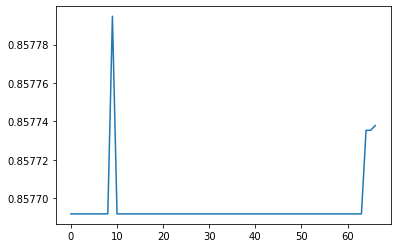

In [64]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
model = make_pipeline(quant_trans_uniform, lgbm)
scores = []

iteration = 0
print('Done iterations: ', end='')
for x in range(147, 1, -1):
    iteration+=1
    columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, x-1, -1)]))
    columns_to_remove += ['Vintage']
    score = cross_val_score(model, X_le_psc.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc').mean()
    scores += [score]
    print(str(iteration) + ",", end='')

scores_series = pd.Series(scores)
plt.plot(scores_series.index, scores_series.values)

I'm sure I can remove 60 columns without affecting model performance, but I still need to look at the results for other scalers.

In [4]:
value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

compare_preprocessing(lgbm, X_le_psc.drop(columns=columns_to_remove), y)

Cross validation time: 5.6952736377716064 seconds
Mean ROC_AUC score without scaler: 0.8574873160321502
Cross validation time: 12.071979999542236 seconds
Mean ROC_AUC score with scaler: 0.8577947969646201
Cross validation time: 162.0033049583435 seconds
Mean ROC_AUC score with transformer: 0.8577408859764913
Cross validation time: 218.17398762702942 seconds
Mean ROC_AUC score with scaler and transformer: 0.8575996426275662
Cross validation time: 15.900956869125366 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8576919569781671
Cross validation time: 24.017045259475708 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578170529189757


The results are the same (even better for QuantileTransformer with normal distribution), but training is much faster (almost a 2-fold improvement for the model version with the transformer!).

### 8.2 Target encoding on Policy_Sales_Channel

The second type of category encoding is supervised encoding. It uses target values to encode category.

In [ ]:
from category_encoders import TargetEncoder

def compare_preprocessing_te(model, X, y, te_columns):
    encoder = TargetEncoder(cols=te_columns)

    scaler = StandardScaler()
    transformer = PowerTransformer()
    scaler_without_std = StandardScaler(with_std=False)
    quant_trans_uniform = QuantileTransformer(output_distribution='uniform')
    quant_trans_normal = QuantileTransformer(output_distribution='normal')

    model_te = make_pipeline(encoder, model)
    model_scaler = make_pipeline(encoder, scaler, model)
    model_transformer = make_pipeline(encoder, transformer, model)
    model_scaler_transformer = make_pipeline(encoder, scaler_without_std, transformer, model)
    model_quant_trans_uniform = make_pipeline(encoder, quant_trans_uniform, model)
    model_quant_trans_normal = make_pipeline(encoder, quant_trans_normal, model)

    cross_val_summary(model_te, X, y, message="Mean ROC_AUC score without scaler: ")
    cross_val_summary(model_scaler, X, y, message="Mean ROC_AUC score with scaler: ")
    cross_val_summary(model_transformer, X, y, message="Mean ROC_AUC score with transformer: ")
    cross_val_summary(model_scaler_transformer, X, y, message="Mean ROC_AUC score with scaler and transformer: ")
    cross_val_summary(model_quant_trans_uniform, X, y, message="Mean ROC_AUC score with QuantileTransformer (uniform distribution): ")
    cross_val_summary(model_quant_trans_normal, X, y, message="Mean ROC_AUC score with QuantileTransformer (normal distribution): ")

In [4]:
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel'])

Cross validation time: 6.895636558532715 seconds
Mean ROC_AUC score without scaler: 0.8578516811768312
Cross validation time: 12.551993131637573 seconds
Mean ROC_AUC score with scaler: 0.8578067917946631
Cross validation time: 162.76739883422852 seconds
Mean ROC_AUC score with transformer: 0.8577500725688326
Cross validation time: 219.64318704605103 seconds
Mean ROC_AUC score with scaler and transformer: 0.857805818285436
Cross validation time: 17.547009229660034 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8577424395726098
Cross validation time: 24.262820720672607 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8578096972047613


Except for the QuantileTransformer with a normal distribution, all results are better. 

I checked, and the results without the original Policy_Sales_Channel column are worse.

## 9. TargetEncoding on Region_Code

Without the original Region_Code column:

In [5]:
compare_preprocessing_te(lgbm, X_le_psc_te, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.385013580322266 seconds
Mean ROC_AUC score without scaler: 0.8578672559914619
Cross validation time: 12.798346519470215 seconds
Mean ROC_AUC score with scaler: 0.8580431893748506
Cross validation time: 163.73356127738953 seconds
Mean ROC_AUC score with transformer: 0.8580417526017181
Cross validation time: 218.94549584388733 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580898524585432
Cross validation time: 17.591765880584717 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.858124605199893
Cross validation time: 24.033880710601807 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8579435208664062


With the original Region_Code column:

In [6]:
X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

compare_preprocessing_te(lgbm, X_le_psc_te_rc, y, ['Policy_Sales_Channel', 'Region_Code'])

Cross validation time: 7.1955201625823975 seconds
Mean ROC_AUC score without scaler: 0.8582197639563397
Cross validation time: 12.822477102279663 seconds
Mean ROC_AUC score with scaler: 0.8581328309025407
Cross validation time: 163.78668522834778 seconds
Mean ROC_AUC score with transformer: 0.8583319013615907
Cross validation time: 221.69700169563293 seconds
Mean ROC_AUC score with scaler and transformer: 0.8580616992741815
Cross validation time: 18.147982358932495 seconds
Mean ROC_AUC score with QuantileTransformer (uniform distribution): 0.8580370579413217
Cross validation time: 24.764060258865356 seconds
Mean ROC_AUC score with QuantileTransformer (normal distribution): 0.8581242602095361


The version with PowerTransformer and the additional, original column "Region_Code" yields the best results, so I'll use that for future analyses.

# 10. Feature selection

In [1]:
# TODO: remove this cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']

In [2]:
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
X_final = X_le_psc_te_rc
fixed_columns = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel', 'Policy_Sales_Channel_te', 'Region_Code_te']
columns_to_remove = []
columns_to_remove_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_remove_len_before_cycle = len(columns_to_remove)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in X_final.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
    base_score = cross_val_score(model, X_final.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_without_column = cross_val_score(model, X_final.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_without_column >= base_score:
            base_score = score_without_column
            columns_to_remove += [column]
    if columns_to_remove_len_before_cycle == len(columns_to_remove):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_remove).to_csv('results/columns_to_remov' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_remove)) + " columns was removed")

Starting full cycle number 1
Calculated base score: 0.8583319026420148
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

39,40,41,42,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

64,65,66,67,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

68,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

69,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

70,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

71,72,73,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

74,75,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

76,77,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

78,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

79,80,81,82,83,84,85,86,87,
Score after 1 cycle: 0.8583499969560096
42 columns was removed
Starting full cycle number 2
Calculated base score: 0.8583499969560096
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

15,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

16,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

17,18,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

21,22,23,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

24,25,26,27,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

28,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,
Score after 2 cycle: 0.8583605770849971
47 columns was removed
Starting full cycle number 3
Calculated base score: 0.8583605770849971
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

1,2,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

3,4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

5,6,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,9,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

10,11,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

12,13,14,15,16,17,18,19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

21,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

22,23,24,25,26,27,28,29,30,31,32,33,34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,37,38,39,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

40,
Score after 3 cycle: 0.8583761424194671
50 columns was removed
Starting full cycle number 4
Calculated base score: 0.8583761424194671
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

1,2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

5,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

6,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,9,10,11,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

12,13,14,15,16,17,18,19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

21,22,23,24,25,26,27,28,29,30,31,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

36,37,
Score after 4 cycle: 0.8583790515431551
52 columns was removed
Starting full cycle number 5
Calculated base score: 0.8583790515431551
Finished iterations: 1,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

4,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

5,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

6,7,8,9,10,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

11,12,13,14,15,16,17,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

18,19,20,21,22,23,24,25,26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

31,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

34,35,
No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

In [8]:
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]
X_final.drop(columns=selected_to_remove)
cross_val_summary(model, X_final.drop(columns=selected_to_remove), y)

Cross validation time: 73.4052996635437 seconds
Mean score: 0.8583790502627309


## 12. Region_Code OHE and feature selection

In [14]:
X_le.Region_Code.value_counts()

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: Region_Code, dtype: int64

There are no really small categories, but still - the smallest one has 183 samples and the biggest one has over 100k samples.

In [15]:
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_rc_ohe, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581446785145823

In [18]:
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

In [19]:
# BACKWARD SELECTION

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_remove = []
columns_to_remove_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_remove_len_before_cycle = len(columns_to_remove)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in X_rc_ohe.drop(columns=columns_to_remove).columns.values if col not in fixed_columns]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe.drop(columns=columns_to_remove), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_without_column = cross_val_score(model, X_rc_ohe.drop(columns=columns_to_remove+[column]), y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_without_column >= base_score:
            base_score = score_without_column
            columns_to_remove += [column]
    if columns_to_remove_len_before_cycle == len(columns_to_remove):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_remove).to_csv('results/columns_to_remove_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_remove)) + " columns was removed")

Starting full cycle number 1
Number of iters in this cycle: 53
Calculated base score: 0.8581446785145823
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

36,37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

39,40,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

41,42,43,44,45,46,47,48,49,50,51,52,53,
Score after 1 cycle: 0.8583419523630965
7 columns was removed
Starting full cycle number 2
Number of iters in this cycle: 46
Calculated base score: 0.8583419523630965
Finished iterations: 1,2,3,4,5,6,7,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

8,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

9,10,11,12,13,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

14,15,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

16,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

17,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

18,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

19,20,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

21,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

22,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

23,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

24,25,26,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

45,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

46,
Score after 2 cycle: 0.8583419523630965
8 columns was removed
Starting full cycle number 3
Number of iters in this cycle: 45
Calculated base score: 0.8583419523630965
Finished iterations: 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

1,2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

KeyboardInterrupt: 

In [20]:
# FORWARD SELECTION

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 0
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = []
columns_to_add_len_before_cycle = 0

while True:
    full_cycle_iter += 1
    columns_to_add_len_before_cycle = len(columns_to_add)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_with_column = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_with_column >= base_score:
            base_score = score_with_column
            columns_to_add += [column]

    if columns_to_add_len_before_cycle == len(columns_to_add):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_add).to_csv('results/columns_to_add_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_add)) + " columns was added")

Starting full cycle number 1
Number of iters in this cycle: 53
Calculated base score: 0.8583790515431551
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

26,27,28,29,30,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

31,32,33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

38,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

39,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

40,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

41,42,43,44,45,46,47,48,49,50,51,52,53,
Score after 1 cycle: 0.8583829382706879
4 columns was added
Starting full cycle number 2
Number of iters in this cycle: 49
Calculated base score: 0.8583829382706879
Finished iterations: 1,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2,3,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

KeyboardInterrupt: 

In [1]:
# TODO: remove this cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

In [2]:
# FORWARD SELECTION step 2
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
transformer = PowerTransformer()
model = make_pipeline(encoder, transformer, lgbm)

full_cycle_iter = 1
cycle_score = None
fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]
columns_to_add_len_before_cycle = 4

while True:
    full_cycle_iter += 1
    columns_to_add_len_before_cycle = len(columns_to_add)
    print("Starting full cycle number " + str(full_cycle_iter))
    selection_columns = [col for col in rc_ohe.columns if col not in fixed_columns and col not in columns_to_add]
    print("Number of iters in this cycle: " + str(len(selection_columns)))
    base_score = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
    if cycle_score is None:
        cycle_score = base_score
    print("Calculated base score: " + str(base_score))
    counter=0
    print("Finished iterations: ", end='')
    for column in selection_columns:
        score_with_column = cross_val_score(model, X_rc_ohe[fixed_columns + columns_to_add + [column]], y, cv=10, scoring='roc_auc', n_jobs=-1).mean()
        counter += 1
        print(str(counter) + ",", end='')
        if score_with_column >= base_score:
            base_score = score_with_column
            columns_to_add += [column]

    if columns_to_add_len_before_cycle == len(columns_to_add):
        print()
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_to_add).to_csv('results/columns_to_add_rc' + str(full_cycle_iter) + '.csv')
    print()
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_to_add)) + " columns was added")

Starting full cycle number 2
Number of iters in this cycle: 49
Calculated base score: 0.8583829382706879
Finished iterations: 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

29,30,31,32,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

33,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

34,35,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

36,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

37,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

38,39,40,41,42,43,44,45,46,47,48,49,
No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

# Partial PowerTransformer

In [8]:
from sklearn.compose import ColumnTransformer

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])

full_cycle_iter = 0
cycle_score = None
columns_wo_tran_len_before_cycle = 0
columns_without_transformer = []
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

while True:
    all_columns = [x for x in X_reduce_te.columns.values if x not in columns_without_transformer]
    full_cycle_iter += 1
    print("Starting full cycle number " + str(full_cycle_iter))
    print("All columns number: " + str(len(all_columns)))
    columns_wo_tran_len_before_cycle = len(columns_without_transformer)
    transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
    model = make_pipeline(encoder, transformer, lgbm)
    base_score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and whole dataset
    print("Base score: " + str(base_score))
    if cycle_score is None:
        cycle_score = base_score
    counter = 0
    print("Iterations finished: ", end='')
    for column in all_columns:
        columns_for_transformer = [x for x in all_columns if x not in columns_without_transformer + [column]]
        transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), columns_for_transformer)])
        model = make_pipeline(encoder, transformer, lgbm)

        score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()  # TODO: set cv=10 and whole dataset
        counter += 1
        print(str(counter), end='')
    
        if score >= base_score:
            base_score = score
            print("Score for transformer without " + column + " column: " + str(score))
            columns_without_transformer += [column]
    
    if columns_wo_tran_len_before_cycle == len(columns_without_transformer):
        print("No columns added in this cycle")
        break
    else:
        cycle_score = base_score

    pd.Series(columns_without_transformer).to_csv('results/columns_without_transformer' + str(full_cycle_iter) + '.csv')
    print("Score after " + str(full_cycle_iter) + " cycle: " + str(base_score))
    print(str(len(columns_without_transformer)) + " columns was removed")
    print()

Starting full cycle number 1
All columns number: 50
Base score: 0.8583829382706879
Iterations finished: 123456789101112131415161718192021222324252627282930

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

3132

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

3738

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

394041

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

42

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

434445

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

4647Score for transformer without Region_Code_0.0 column: 0.8583829382706879
4849Score for transformer without Region_Code_38.0 column: 0.8583829382706879
50Score for transformer without Region_Code_52.0 column: 0.8583829382706879
Score after 1 cycle: 0.8583829382706879
3 columns was removed

Starting full cycle number 2
All columns number: 47
Base score: 0.8583829382706879
Iterations finished: 12345678910111213

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

1415

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

161718

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

19202122

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2324

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

25

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

26

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

2728293031

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

32

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

333435363738394041424344454647No columns added in this cycle


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

We have the same score, but the model is slightly faster - now it doesn't need to transform three columns. It's not a big improvement, but I'll use it for faster tuning.

## TargetEncoding on Vehicle_Age

In [7]:
X_vage_te = X_reduce_te.copy()

transformer_columns = [x for x in X_vage_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code', 'Vehicle_Age'])
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), transformer_columns)])

model = make_pipeline(encoder, transformer, lgbm)
cross_val_score(model, X_vage_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8580166335152419

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

It doesn't improve the result.

## Oversampling/SMOTE

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

# cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

In [10]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('over', oversample), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581684909994174

In [11]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('over', oversample), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8581055667809746

In [12]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
model = Pipeline([('enc', encoder), ('trans', transformer), ('over', oversample), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.858204569951902

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

In [7]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('smt', smote), ('enc', encoder), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8420298085837888

In [8]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('smt', smote), ('trans', transformer), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.840975800838976

In [9]:
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

smote = SMOTE()
model = Pipeline([('enc', encoder), ('trans', transformer), ('smt', smote), ('lgbm', lgbm)])

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8520831275035989

It didn't improve the result.

## LGBM with AUC metric

In [19]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

lgbm = LGBMClassifier(random_state=42, verbose=-1, eval_metric='auc')
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

0.8583829369902638

[12:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, d

[12:29:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.

[12:29:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

[12:29:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric
[12:29:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[LightGBM] [Warning] Unknown parameter: eval_metric


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-pac

It didn't improve the result.

## Model tuning

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()
counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]

transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'])
model = make_pipeline(encoder, transformer, lgbm)

# cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean()

In [3]:
import optuna
np.seterr(all="ignore")

trials_number = 50 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 8)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.1, 3.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.1,
        "depth_limit": True,
        "max_depth": 5,
        "num_leaves_pow": 5,
        "n_estimators": 100,
        "subsample": 1.0,
        "class_weight": None,
        "te_smoothing": 1.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-01 15:00:16,639] A new study created in memory with name: no-name-478b758f-5f1b-4557-865c-46add1187cf2


Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 37

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 38, 39, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50
Best trial:
  ROC AUC: 0.858814764670927
  Params: 
    learning_rate: 0.009214155727458158
    depth_limit: False
    num_leaves_pow: 6
    n_estimators: 748
    subsample: 0.7116290449402978
    class_weight: None
    te_smoothing: 0.36043121104209824


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

In [14]:
import optuna
np.seterr(all="ignore")

trials_number = 50 # TODO: set higer value

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 9)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 1500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 3.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.009214155727458158,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 6,
        "n_estimators": 748,
        "subsample": 0.7116290449402978,
        "class_weight": None,
        "te_smoothing": 0.36043121104209824
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-02 10:35:34,108] A new study created in memory with name: no-name-bc7c1e44-33dd-4e9e-a37d-6322b49b66fe


Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/h

, 32

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 34, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 37

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 38, 39, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 41

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 42, 43, 44, 45, 46, 47, 48, 49, 50
Best trial:
  ROC AUC: 0.8588175241512397
  Params: 
    learning_rate: 0.005017264032393435
    depth_limit: False
    num_leaves_pow: 6
    n_estimators: 1469
    subsample: 0.47151419221112034
    class_weight: None
    te_smoothing: 2.9510219777055813


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

In [3]:
import optuna
np.seterr(all="ignore")

trials_number = 100

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = -1
    depth_limit = trial.suggest_categorical("depth_limit", [True, False])
    if depth_limit is True:
        max_depth = trial.suggest_int("max_depth", 2, 9)
    num_leaves_pow = trial.suggest_int("num_leaves_pow", 2, 9)
    num_leaves = 2 ** num_leaves_pow
    n_estimators = trial.suggest_int('n_estimators', 50, 2500)
    subsample = trial.suggest_uniform('subsample', 0.3, 1.0)
    class_weight = trial.suggest_categorical("class_weight", [None, 'balanced'])
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 5.0)
    reg_alpha = trial.suggest_uniform("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_uniform("reg_lambda", 0.0, 1.0)

    
    lgbm = LGBMClassifier(random_state=42, verbose=-1, learning_rate=learning_rate, max_depth=max_depth, num_leaves=num_leaves, n_estimators=n_estimators, subsample=subsample, class_weight=class_weight)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, lgbm)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    if trial.number == 0:
        print("Finished trials: 1", end="")
    else:
        print(", " + str(trial.number+1), end="")
    return score

study = optuna.create_study(direction="maximize")

study.enqueue_trial({
        "learning_rate": 0.005017264032393435,
        "depth_limit": False,
        "max_depth": 5,
        "num_leaves_pow": 6,
        "n_estimators": 1469,
        "subsample": 0.47151419221112034,
        "class_weight": None,
        "te_smoothing": 2.9510219777055813,
        "reg_alpha": 0.0,
        "reg_lambda": 0.0
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective, n_trials=trials_number)

print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Finished trials: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 31, 32, 33

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 34

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 35

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 36

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 37, 38

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 39

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 40

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 41, 42, 43, 44, 45

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 65, 66

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 67, 68, 69, 70

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where

, 71, 72

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 73

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 74

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 75, 76

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

, 77, 78

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered

, 79, 80, 81, 82, 83, 84, 85

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

, 99, 100
Best trial:
  ROC AUC: 0.8588986626649424
  Params: 
    learning_rate: 0.010259408143780216
    depth_limit: True
    max_depth: 5
    num_leaves_pow: 9
    n_estimators: 2371
    subsample: 0.6951379234882272
    class_weight: None
    te_smoothing: 0.6741836510673999
    reg_alpha: 0.163111686021624
    reg_lambda: 0.2639575808284711


/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x,

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, 

/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/jsowa/anaconda3/envs/healthnewsklearn/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered

## XGB model
eXtreme Gradient Boosting is a more powerful but slower algorithm. LightGBM can sometimes obtain higher performance, but usually XGBoost has a slightly better result and significantly slower execution time. A detailed comparison of these algorithms would be too long for this article, so I encourage you to watch [this video](https://www.youtube.com/watch?v=5CWwwtEM2TA) if you're interested in the topic.

In [1]:
# TODO: remove cell
from articlecommon import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
lgbm = LGBMClassifier(random_state=42, verbose=-1)
psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")
X_le_psc = pd.concat([X_le, psc_ohe], axis=1)



psc_ohe = pd.get_dummies(X_le["Policy_Sales_Channel"], prefix="Policy_Sales_Channel")

counts = X_le["Policy_Sales_Channel"].value_counts()

counts = counts[counts == 1]
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(x), counts.index.tolist()))
psc_ohe = psc_ohe.drop(columns=columns_to_remove)

X_le_psc = pd.concat([X_le, psc_ohe], axis=1)

value_counts = X_le_psc["Policy_Sales_Channel"].value_counts().index
columns_to_remove = list(map(lambda x: "Policy_Sales_Channel_" + str(value_counts[x]), [*range(147, 86, -1)]))
columns_to_remove += ['Vintage']

from category_encoders import TargetEncoder
X_le_psc_te = X_le_psc.drop(columns=columns_to_remove).copy()
X_le_psc_te['Policy_Sales_Channel_te'] = X_le_psc_te['Policy_Sales_Channel']

X_le_psc_te_rc = X_le_psc_te.copy()
X_le_psc_te_rc['Region_Code_te'] = X_le_psc_te_rc['Region_Code']
selected_to_remove = pd.read_csv('results/columns_to_remov4.csv', index_col=0)["0"]

X_final = X_le_psc_te_rc
X_rc_ohe = X_final.drop(columns=selected_to_remove)
rc_ohe = pd.get_dummies(X_rc_ohe["Region_Code"], prefix="Region_Code")
X_rc_ohe = pd.concat([X_rc_ohe, rc_ohe], axis=1)

fixed_columns = [x for x in X_rc_ohe if x not in rc_ohe.columns]
columns_to_add = ["Region_Code_0.0", "Region_Code_1.0", "Region_Code_38.0", "Region_Code_52.0"]

encoder = TargetEncoder(cols=['Region_Code', 'Policy_Sales_Channel'])
# X_reduce_te = X_rc_ohe[fixed_columns + columns_to_add]
X_reduce_te = X_rc_ohe.loc[:, fixed_columns + columns_to_add]

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]



In [3]:
import optuna
np.seterr(all="ignore")

all_columns = [x for x in X_reduce_te.columns.values if x not in ["Region_Code_0.0", "Region_Code_38.0", "Region_Code_52.0"]]
transformer = ColumnTransformer(transformers=[('pwrtrans', PowerTransformer(), all_columns)])


def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1.0)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    subsample = trial.suggest_uniform('subsample', 0.4, 1.0)
    te_smoothing = trial.suggest_loguniform("te_smoothing", 0.05, 10.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7)
    gamma = trial.suggest_uniform("gamma", 0.0, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 1.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 1e2)

    
    xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
    model = make_pipeline(encoder, transformer, xgb)

    score = cross_val_score(model, X_reduce_te, y, cv=10, scoring='roc_auc', n_jobs=-1).mean() # TODO: set cv=10 and the whole dataset
    print("  ROC AUC: {}".format(score))

    print("  Params for trial " + str(trial.number) + ": ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    return score

In [3]:
trials_number = 70 # TODO: set higer value

study_name = 'xgb-study'
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, direction="maximize", storage=storage_name, load_if_exists=True,)

study.enqueue_trial({
        "learning_rate": 0.05014352877833517,
        "max_depth": 7,
        "min_child_weight": 5,
        "n_estimators": 234,
        "subsample": 0.9009423215546716,
        "class_weight": None,
        "te_smoothing": 0.20145207364872467,
        "gamma": 0.2491618356357863,
        "colsample_bytree": 0.631803937308591,
        "reg_alpha": 0.025408324931767336
    })

optuna.logging.set_verbosity(optuna.logging.WARNING)
# study.optimize(objective, n_trials=trials_number)

[I 2022-12-13 13:28:49,624] Using an existing study with name 'xgb-study' instead of creating a new one.


As you can see, I have commented the last line. Tuning takes a lot of time and resources. I have finished it outside of this notebook, and here I'll just load the final parameters.

In [4]:
print("\nBest trial:")
trial = study.best_trial

print("  ROC AUC: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Best trial:
  ROC AUC: 0.8590739770495592
  Params: 
    colsample_bytree: 0.759012193204171
    gamma: 0.20241066830358567
    learning_rate: 0.021291366221284337
    max_depth: 8
    min_child_weight: 5
    n_estimators: 476
    reg_alpha: 0.010982331080557824
    subsample: 0.8706268352745364
    te_smoothing: 0.35648520716557985


In [4]:
learning_rate = 0.021291366221284337
max_depth = 8
n_estimators = 476
subsample = 0.8706268352745364
te_smoothing = 0.35648520716557985
min_child_weight = 5
gamma = 0.20241066830358567
colsample_bytree = 0.759012193204171
reg_alpha = 0.010982331080557824


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_reduce_te, y)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'],
                               smoothing=0.35648520716557985)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pwrtrans',
                                                  PowerTransformer(),
                                                  ['Gender', 'Age',
                                                   'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Po...
                               interaction_constraints='',
                               learning_rate=0.021291366221284337,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=476,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.010982331080557824, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8706268352745364,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [14]:
xgb.save_model("xgb-model.json")

## Model explainability

After some fancy tricks model get reasonable outcome. But what he really does? Does he consider the features we highlighted in our initial analysis to be just as important?

List of features in final model is longer, so let's calculate again mutual information for all of these:

In [19]:
mi = mutual_info_classif(X_reduce_te, y, random_state=42)
pd.Series(mi, name="MI Scores", index=X_reduce_te.columns).sort_values(ascending=False)

Previously_Insured            0.099039
Vehicle_Damage                0.093762
Driving_License               0.073882
Policy_Sales_Channel          0.059375
Policy_Sales_Channel_te       0.058788
Vehicle_Age                   0.042300
Policy_Sales_Channel_152.0    0.038150
Age                           0.030981
Gender                        0.022686
Region_Code                   0.015256
Region_Code_te                0.014942
Policy_Sales_Channel_26.0     0.009462
Policy_Sales_Channel_124.0    0.006754
Annual_Premium                0.003393
Policy_Sales_Channel_157.0    0.001633
Policy_Sales_Channel_16.0     0.001210
Policy_Sales_Channel_4.0      0.001207
Policy_Sales_Channel_30.0     0.001015
Policy_Sales_Channel_155.0    0.000912
Policy_Sales_Channel_13.0     0.000721
Policy_Sales_Channel_154.0    0.000667
Policy_Sales_Channel_52.0     0.000666
Policy_Sales_Channel_151.0    0.000590
Region_Code_52.0              0.000538
Policy_Sales_Channel_29.0     0.000536
Region_Code_1.0          

### Feature importances

Trained model gives us some statistics about features. I will print them using "plot_importance" function:

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

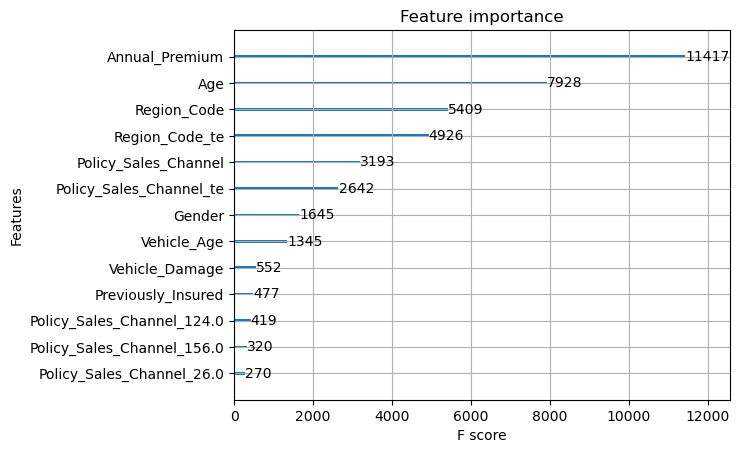

In [7]:
from xgboost import plot_importance
import xgboost
xgb_loaded = xgboost.Booster()
xgb_loaded.load_model("xgb-model.json")
xgb_loaded.feature_names = X_reduce_te.columns.values.tolist()
plot_importance(xgb_loaded, height=0.1, max_num_features=13)

F7 - annual premium
f1 - age
f3 - region_code
f45 - region_code_te
f8 - Policy_Sales_Channel
f44 - Policy_Sales_Channel_te
f0 - Gender
f5 - Vehicle_Age
f6 - Vehicle_Damage
f4 - Previously_Insured
f31 - Polisy_Sales_Channel_124
f41 - Polisy_Sales_Channel_156
f20 - Policy_Sales_Channel_26.0

The conclusions are not identical, but we can see similarities. In three most important Policy_Sales_Channel One Hot Encoding columns there are number 124 and 26. Original, non-transformed columns have very high score, but their order is different.

## Graphviz

In [4]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(xgb_loaded, out_file=None, feature_names=X_reduce_te.columns)
graphviz.Source(tree_graph)

TypeError: <xgboost.core.Booster object at 0x7f39ca4a3bb0> is not an estimator instance.

In [3]:
learning_rate = 0.021291366221284337
max_depth = 8
n_estimators = 476
subsample = 0.8706268352745364
te_smoothing = 0.35648520716557985
min_child_weight = 5
gamma = 0.20241066830358567
colsample_bytree = 0.759012193204171
reg_alpha = 0.010982331080557824


xgb = XGBClassifier(random_state=42, eval_metric="logloss", learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, subsample=subsample, min_child_weight=min_child_weight, gamma=gamma, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
encoder = TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'], smoothing=te_smoothing)
model = make_pipeline(encoder, transformer, xgb)
model.fit(X_reduce_te, y)

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Policy_Sales_Channel', 'Region_Code'],
                               smoothing=0.35648520716557985)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('pwrtrans',
                                                  PowerTransformer(),
                                                  ['Gender', 'Age',
                                                   'Driving_License',
                                                   'Region_Code',
                                                   'Previously_Insured',
                                                   'Vehicle_Age',
                                                   'Vehicle_Damage',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Po...
                               interaction_constraints='',
                               learning_rate=0.021291366221284337,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=476,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0.010982331080557824, reg_lambda=1,
                               scale_pos_weight=1, subsample=0.8706268352745364,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [33]:
from sklearn import tree
import graphviz
from xgboost import plot_tree

# tree_graph = tree.export_graphviz(xgb, out_file=None)
# graphviz.Source(tree_graph)
fig, ax = plt.subplots(figsize=(1, 1))
plot_tree(xgb, num_trees=1, ax=ax)
plt.show()

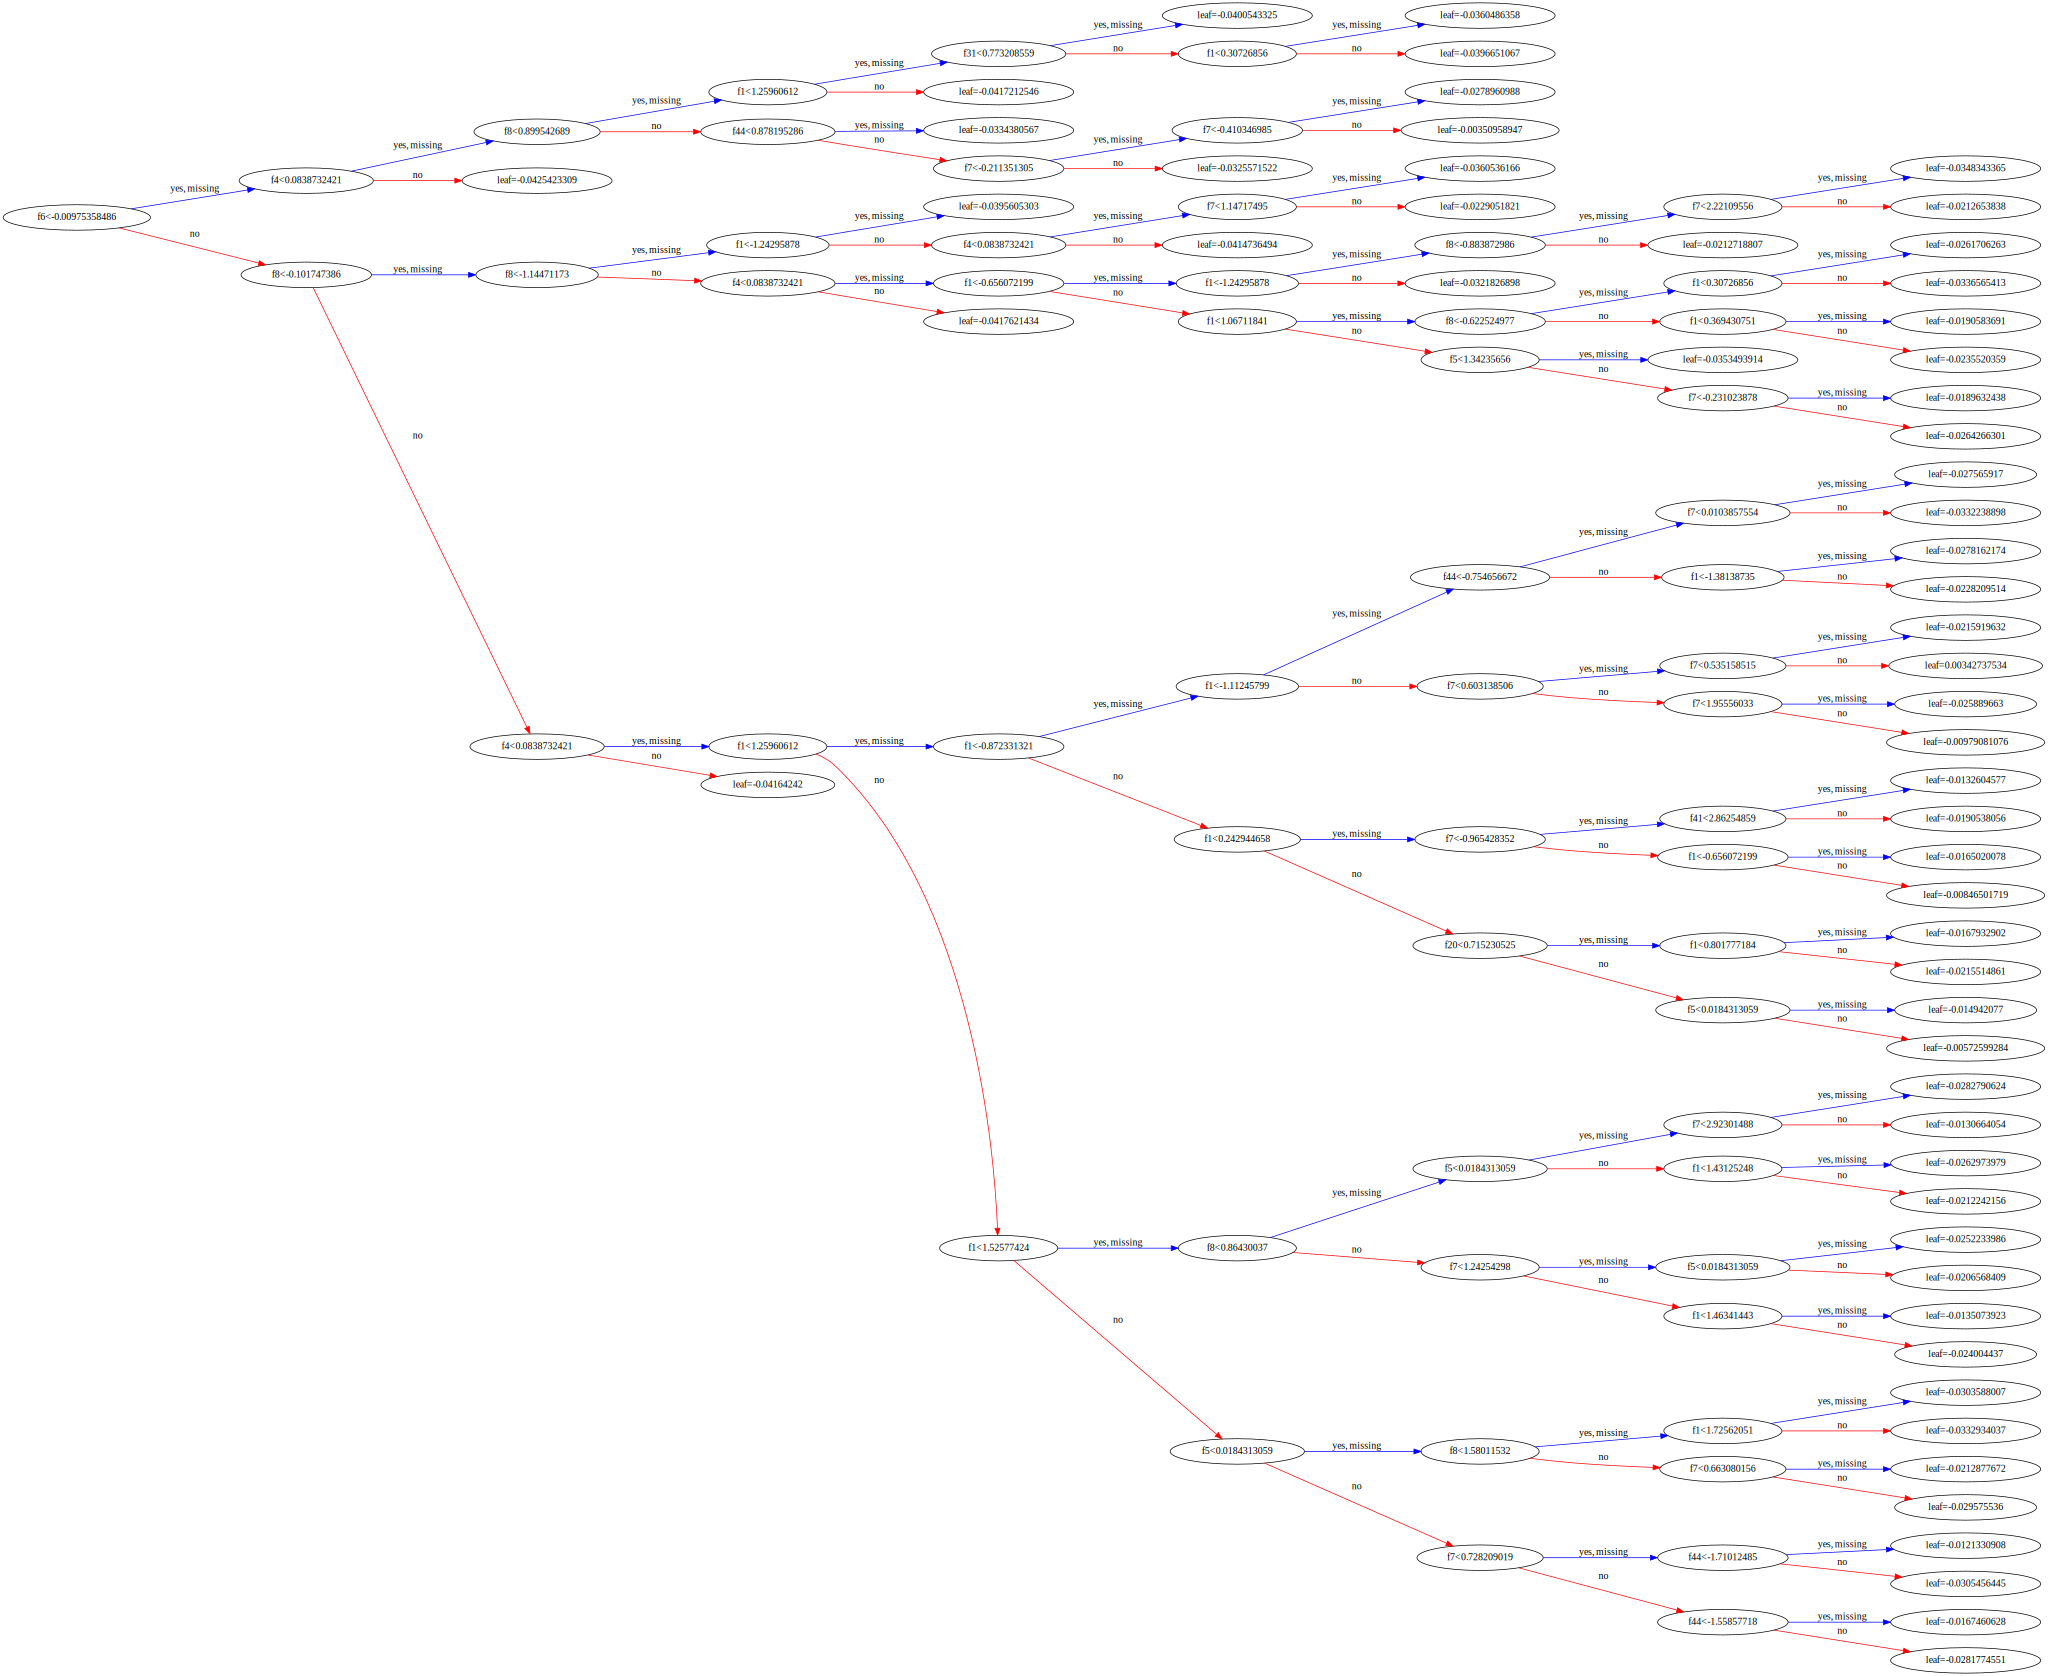

In [16]:
from sklearn import tree
import graphviz
from xgboost import to_graphviz

# tree_graph = tree.export_graphviz(xgb, out_file=None)
# graphviz.Source(tree_graph)

to_graphviz(xgb, num_trees=0, rankdir='LR')
# plt.show()

<AxesSubplot:>

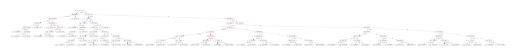

In [38]:
import xgboost
xgboost.plot_tree(booster = xgb, n_first_tree = 100)

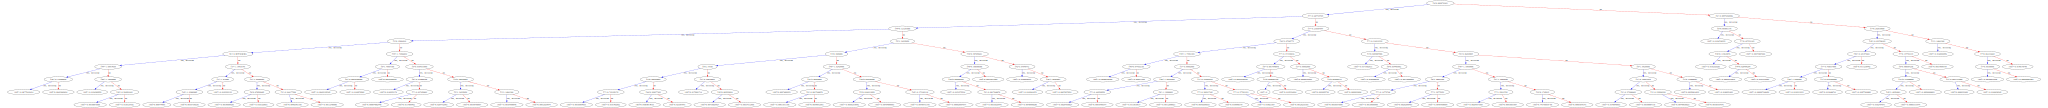

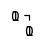

In [28]:
fig, ax = plt.subplots(figsize=(0.001, 0.001))
to_graphviz(xgb, num_trees=240, ax=ax)

### Permutation importance

In [18]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42, cv='prefit').fit(X_reduce_te, y)
eli5.show_weights(perm, feature_names = X_reduce_te.columns.values)

Weight,Feature
0.0048 ± 0.0002,Annual_Premium
0.0036 ± 0.0003,Vehicle_Age
0.0007 ± 0.0001,Policy_Sales_Channel_152.0
0.0006 ± 0.0003,Region_Code
0.0005 ± 0.0004,Region_Code_te
0.0002 ± 0.0007,Age
0 ± 0.0000,Policy_Sales_Channel_15.0
0 ± 0.0000,Policy_Sales_Channel_30.0
0 ± 0.0000,Policy_Sales_Channel_29.0
0 ± 0.0000,Policy_Sales_Channel_25.0


Previously_Insured      0.079515
Vehicle_Damage          0.079027
Annual_Premium          0.068894
Policy_Sales_Channel    0.059944
Age                     0.030097
Vehicle_Age             0.026214
Region_Code             0.009445
Gender                  0.001388
Vintage                 0.000342
Driving_License         0.000064

### pdpbox

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

feature_names = "TODO"
selected_feature = "TODO"

pdp_isolated = pdp.pdp_isolate(model=model, dataset=X_reduce_te, model_features=feature_names, feature=selected_feature)

pdp.pdp_plot(pdp_isolated, 'TODO')
plt.show()